# Trend Checking Tool:
### For long positions (opposite for shorts):
#### 1. Price is above the 200-day moving average
#### 2. Price is above the 30-day moving average
#### 3. 200-day moving average slope is rising
#### 4. 30-day moving average slope is rising
#### 5. The last touch of the 20-day max/min lines was max
#### 0-5 Star rating

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import yfinance as yf
import requests
import pandas_datareader as pdr

In [8]:
def trend_strength(dataframe=False, dataframe_column=None, position='long', 
                   yahoo_download=True, yahoo_ticker = None, plot_chart=True, yrs_needed=2):
    
    # Data input
    data_len = -252 * yrs_needed
    if yahoo_download:
        df = yf.download(yahoo_ticker, period='max', interval="1d")['Adj Close'][data_len:]
        df.dropna(inplace=True)

        df = df.to_frame(name='Security')
        df['30_day_MA'] = df.Security.rolling(window=30).mean().shift() #shift so no lookahead bias
        df['200_day_MA'] = df.Security.rolling(window=200).mean().shift()
        df['max_line'] = df.Security.rolling(20).apply(lambda x: x.max()).shift()
        df['min_line'] = df.Security.rolling(20).apply(lambda x: x.min()).shift()
        df.index = df.index.strftime('%Y-%m/%d')
        df.dropna(inplace=True)
    elif dataframe:
        df = dataframe_column.iloc[data_len:,dataframe_column]
        df = df.to_frame(name='Security')
        df['30_day_MA'] = df.Security.rolling(window=30).mean().shift() #shift so no lookahead bias
        df['200_day_MA'] = df.Security.rolling(window=200).mean().shift()
        df['max_line'] = df.Security.rolling(20).apply(lambda x: x.max()).shift()
        df['min_line'] = df.Security.rolling(20).apply(lambda x: x.min()).shift()
        df.index = df.index.strftime('%Y-%m/%d')
        df.dropna(inplace=True)
    
    # Trend signal
    pd.options.mode.chained_assignment = None  # default='warn'
    if position == 'long':
        df['30D_MA_Rating'], df['200D_MA_Rating'], df['Rising_200MA_Rating'], df['Rising_30MA_Rating'] = [0,0,0,0]
        df['MAXMIN_Rating'], df['Rating']  = [0,0]

        df['30D_MA_Rating'] = np.where(df.Security > df['30_day_MA'], 1, 0)
        df['200D_MA_Rating'] = np.where(df.Security > df['200_day_MA'], 1, 0)
        df['Rising_200MA_Rating'] = np.where(df['200_day_MA'] > df['200_day_MA'].shift(), 1, 0)
        df['Rising_30MA_Rating'] = np.where(df['30_day_MA'] > df['30_day_MA'].shift(), 1, 0)

        df['MaxTouch_Date'] = np.where(df.Security >= df['max_line'], df.index, np.nan)
        df['MinTouch_Date'] = np.where(df.Security <= df['min_line'], df.index, np.nan)
        df.fillna(axis=0, method='ffill', inplace=True)
        df.dropna(inplace=True)
        df['MAXMIN_Rating'] = np.where(df['MaxTouch_Date'] > df['MinTouch_Date'], 1, 0)
        df['Rating'] = np.sum([df['30D_MA_Rating'], df['200D_MA_Rating'], 
                                   df['Rising_200MA_Rating'], df['Rising_30MA_Rating'], df['MAXMIN_Rating']], axis=0)
        
        print(f"{df['Rating'][df.shape[0]-1]} Star Trend for your long position")
    
    elif position == 'short':
        df['30D_MA_Rating'], df['200D_MA_Rating'], df['Falling_200MA_Rating'], df['Falling_30MA_Rating'] = [0,0,0,0]
        df['MAXMIN_Rating'], df['Rating']  = [0,0]

        df['30D_MA_Rating'] = np.where(df.Security < df['30_day_MA'], 1, 0)
        df['200D_MA_Rating'] = np.where(df.Security < df['200_day_MA'], 1, 0)
        df['Falling_200MA_Rating'] = np.where(df['200_day_MA'] < df['200_day_MA'].shift(), 1, 0)
        df['Falling_30MA_Rating'] = np.where(df['30_day_MA'] < df['30_day_MA'].shift(), 1, 0)

        df['MaxTouch_Date'] = np.where(df.Security >= df['max_line'], df.index, np.nan)
        df['MinTouch_Date'] = np.where(df.Security <= df['min_line'], df.index, np.nan)
        df.fillna(axis=0, method='ffill', inplace=True)
        df.dropna(inplace=True)
        df['MAXMIN_Rating'] = np.where(df['MaxTouch_Date'] < df['MinTouch_Date'], 1, 0)
        df['Rating'] = np.sum([df['30D_MA_Rating'], df['200D_MA_Rating'], 
                                   df['Falling_200MA_Rating'], df['Falling_30MA_Rating'], df['MAXMIN_Rating']], axis=0)

        print(f"{df['Rating'][df.shape[0]-1]} Star Trend for your short position")
    
    # Plot trend signal with price
    if plot_chart:
        df.index = pd.to_datetime(df.index)
        fig, ax = plt.subplots(figsize=(12,6), sharey=False)
        l1 = ax.plot(df.Security, label='Price')
        ax.set_ylabel('Security Price')
        ax2 = ax.twinx()
        l2 = ax2.bar(x=df.index, height=df.Rating, alpha=0.1, color='r', label='Trend Rating', width=1.0)
        ax2.set_ylabel('Rating')
        ax2.set_ylim(0,5)
        plt.xlim(df.index[0], df.index[-1])
        plt.legend(loc='upper center')
        plt.title(f'Trend Signal', fontsize=15)

[*********************100%***********************]  1 of 1 completed
4 Star Trend for your long position


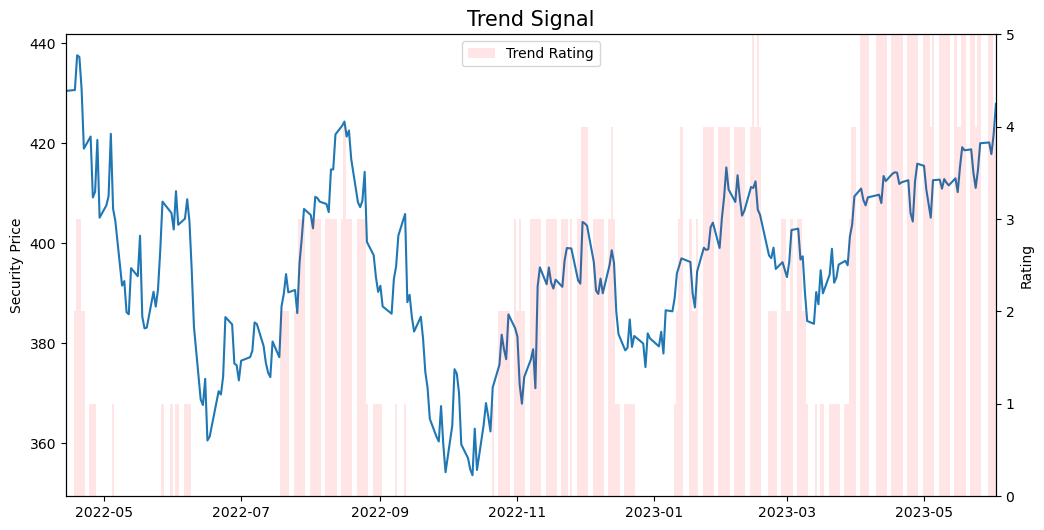

In [9]:
trend_strength(position='long', yahoo_download=True, yahoo_ticker = 'SPY')

# Example: S&P 500 Trend (long position)

In [10]:
df = yf.download('SPY', period='max', interval="1d")['Adj Close'][-504:]
df.dropna(inplace=True)
df = df.iloc[-1000:,]

df = df.to_frame(name="SPX_Price")
df['30_day_MA'] = df.SPX_Price.rolling(window=30).mean().shift() #shift so no lookahead bias
df['200_day_MA'] = df.SPX_Price.rolling(window=200).mean().shift()
df['max_line'] = df.SPX_Price.rolling(20).apply(lambda x: x.max()).shift()
df['min_line'] = df.SPX_Price.rolling(20).apply(lambda x: x.min()).shift()
df.index = df.index.strftime('%Y-%m/%d')
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,SPX_Price,30_day_MA,200_day_MA,max_line,min_line
Date,,,,,
2022-03/18,437.114197,426.829322,435.419597,432.378448,408.047546
2022-03/21,436.986389,426.806481,435.572946,437.114197,408.047546
2022-03/22,442.099731,426.710756,435.707068,437.114197,408.047546
2022-03/23,436.406158,426.832533,435.868747,442.099731,408.047546
2022-03/24,442.984711,426.644273,436.001522,442.099731,408.047546


In [11]:
## SIGNAL
# Long position:
pd.options.mode.chained_assignment = None 
df['30D_MA_Rating'], df['200D_MA_Rating'], df['Rising_200MA_Rating'], df['Rising_30MA_Rating'] = [0,0,0,0]
df['MAXMIN_Rating'], df['Rating']  = [0,0]

df['30D_MA_Rating'] = np.where(df.SPX_Price > df['30_day_MA'], 1, 0)
df['200D_MA_Rating'] = np.where(df.SPX_Price > df['200_day_MA'], 1, 0)
df['Rising_200MA_Rating'] = np.where(df['200_day_MA'] > df['200_day_MA'].shift(20), 1, 0)
df['Rising_30MA_Rating'] = np.where(df['30_day_MA'] > df['30_day_MA'].shift(3), 1, 0)

df['MaxTouch_Date'] = np.where(df.SPX_Price >= df['max_line'], df.index, np.nan)
df['MinTouch_Date'] = np.where(df.SPX_Price <= df['min_line'], df.index, np.nan)
df.fillna(axis=0, method='ffill', inplace=True)
df.dropna(inplace=True)
df['MAXMIN_Rating'] = np.where(df['MaxTouch_Date'] > df['MinTouch_Date'], 1, 0)
df['Rating'] = np.sum([df['30D_MA_Rating'], df['200D_MA_Rating'], 
                           df['Rising_200MA_Rating'], df['Rising_30MA_Rating'], df['MAXMIN_Rating']], axis=0)

print(f"{df['Rating'][df.shape[0]-1]} Star Trend for your long position")

5 Star Trend for your long position


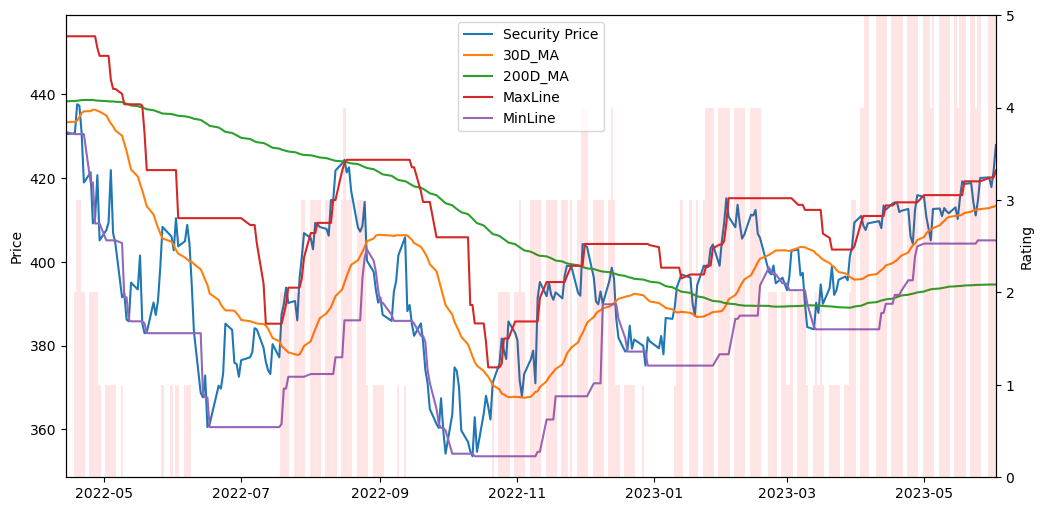

In [12]:
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(12,6), sharey=False)
l1 = ax.plot(df.iloc[:,:5], label=['Security Price', '30D_MA', '200D_MA', 'MaxLine','MinLine'])
ax.set_ylabel('Price')
ax2 = ax.twinx()
l2 = ax2.bar(x=df.index, height=df.Rating, alpha=0.1, color='r', label='Trend Rating', width=1.0)
ax2.set_ylabel('Rating')
ax2.set_ylim(0,5)
plt.xlim(df.index[0], df.index[-1])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center')